In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import roc_curve

In [2]:
def read_data(path_to_file: str) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    data = data[['time', 'displacements_x', 'displacements_y', 'angular_velocity', 'load_value', 'gear_fault_desc']]
    return data

In [3]:
def read_data_and_choose(path_to_file: str, velocity: float, load: bool) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    duration = np.array([round((0.0002 * i), 4) for i in range(data.shape[0])])
    data['time'] = duration
    data['displacements'] = np.sqrt(data['displacements_x']**2 + data['displacements_y']**2)
    data = data[['time', 'displacements_x', 'displacements_y', 'displacements' ,'angular_velocity', 'load_value', 'gear_fault_desc']]
    if load:
        load_value = 80
    else:
        load_value = 0
    data = data[(data['angular_velocity'] == velocity) & (data['load_value'] == load_value)]
    data['time'] = data['time'] - data['time'].iloc[0]
    return data

In [4]:
def do_rfft_features(data: pd.DataFrame) -> pd.DataFrame:
    y = data['defect']
    X = data.drop(columns=['defect']).values
    X = np.abs(np.fft.rfft(X, axis=1))
    data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
    return data

In [5]:
def get_features_and_target(velocity: float, load: bool, n_cols: int) -> pd.DataFrame:
    data_eccentricity = read_data_and_choose('eccentricity.csv', velocity, load)
    data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity, load)
    data_no_fault = read_data_and_choose('no_fault.csv', velocity, load)
    data_root_crack = read_data_and_choose('root_crack.csv', velocity, load)
    data_surface_fault = read_data_and_choose('surface_fault.csv', velocity, load)
    data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity, load)
    
    n_rows = 25000 // n_cols
    remain = 25000 % n_cols
    if remain == 0:
        
        X_1 = data_eccentricity['displacements'].values.reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values.reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values.reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values.reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values.reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    else:
        
        X_1 = data_eccentricity['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'][: -(25000 % n_cols)].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data

In [6]:
def get_all_features_and_targets(n_cols: int, do_fft: bool) -> pd.DataFrame:
    data_1 = get_features_and_target(velocity=8.33203125, load=False, n_cols=n_cols)
    if do_fft:
        data_1 = do_rfft_features(data_1)
    data_1['velocity'] = 8.33203125
    data_1['load'] = 0.0
    data_2 = get_features_and_target(velocity=8.33203125, load=True, n_cols=n_cols)
    if do_fft:
        data_2 = do_rfft_features(data_2)
    data_2['velocity'] = 8.33203125
    data_2['load'] = 80.0
    data_3 = get_features_and_target(velocity=25.0, load=False, n_cols=n_cols)
    if do_fft:
        data_3 = do_rfft_features(data_3)
    data_3['velocity'] = 25.0
    data_3['load'] = 0.0
    data_4 = get_features_and_target(velocity=25.0, load=True, n_cols=n_cols)
    if do_fft:
        data_4 = do_rfft_features(data_4)
    data_4['velocity'] = 25.0
    data_4['load'] = 80.0
    data_5 = get_features_and_target(velocity=40.0, load=False, n_cols=n_cols)
    if do_fft:
        data_5 = do_rfft_features(data_5)
    data_5['velocity'] = 40.0
    data_5['load'] = 0.0
    data_6 = get_features_and_target(velocity=40.0, load=True, n_cols=n_cols)
    if do_fft:
        data_6 = do_rfft_features(data_6)
    data_6['velocity'] = 40.0
    data_6['load'] = 80.0
    data = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6], axis=0)
    data = data.reset_index().drop(columns='index', axis=1)
    data = data.rename(str, axis="columns") 
    return data

In [7]:
df = get_all_features_and_targets(n_cols=150, do_fft=False)
df

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,velocity,load
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672,8.332031,0.0
1,eccentricity,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622,8.332031,0.0
2,eccentricity,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029,8.332031,0.0
3,eccentricity,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815,8.332031,0.0
4,eccentricity,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734,40.000000,80.0
5972,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246,40.000000,80.0
5973,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261,40.000000,80.0
5974,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658,40.000000,80.0


In [8]:
X = df.drop(columns='defect')
y = df['defect']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

In [10]:
labels = sorted(y_test.unique())
labels

['eccentricity',
 'missing_tooth',
 'no_fault',
 'root_crack',
 'surface_fault',
 'tooth_chipped_fault']

Логистическая регрессия

In [11]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_score(y_test, predictions)

0.17307692307692307

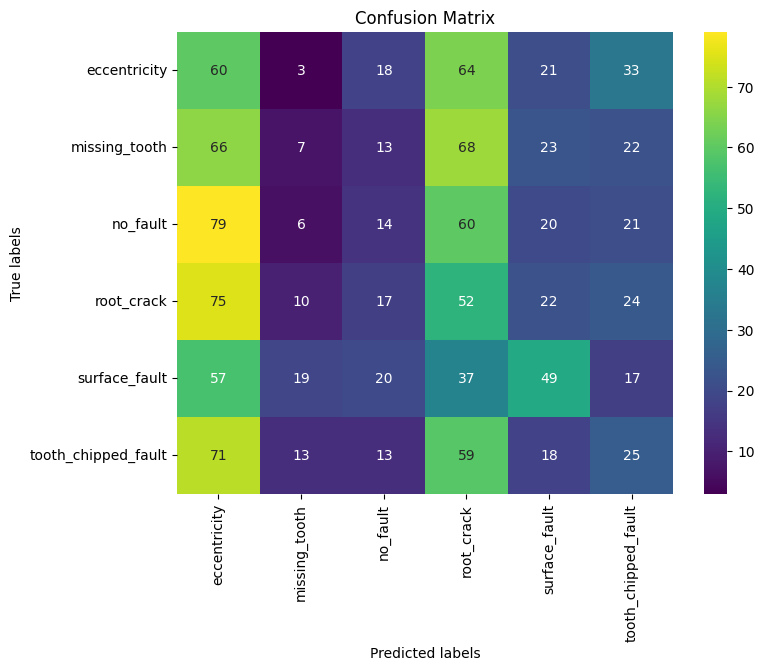

In [12]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class='ovr')

0.4924467686221466

Дерево решений

In [14]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    DecisionTreeClassifier()
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-20 19:19:08,763] A new study created in memory with name: Tree
[I 2024-05-20 19:19:10,717] Trial 0 finished with value: 0.37343096234309625 and parameters: {'max_depth': 67}. Best is trial 0 with value: 0.37343096234309625.
[I 2024-05-20 19:19:12,746] Trial 1 finished with value: 0.3786610878661088 and parameters: {'max_depth': 98}. Best is trial 1 with value: 0.3786610878661088.
[I 2024-05-20 19:19:14,848] Trial 2 finished with value: 0.38389121338912136 and parameters: {'max_depth': 45}. Best is trial 2 with value: 0.38389121338912136.
[I 2024-05-20 19:19:16,997] Trial 3 finished with value: 0.3807531380753138 and parameters: {'max_depth': 35}. Best is trial 2 with value: 0.38389121338912136.
[I 2024-05-20 19:19:19,216] Trial 4 finished with value: 0.3786610878661088 and parameters: {'max_depth': 57}. Best is trial 2 with value: 0.38389121338912136.
[I 2024-05-20 19:19:21,565] Trial 5 finished with value: 0.39539748953974896 and parameters: {'max_depth': 42}. Best is trial

In [15]:
study.best_params

{'max_depth': 21}

In [16]:
best_params = {'max_depth': 148}

In [17]:
d_tree = DecisionTreeClassifier(**study.best_params)
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_score(y_test, predictions)

0.3787625418060201

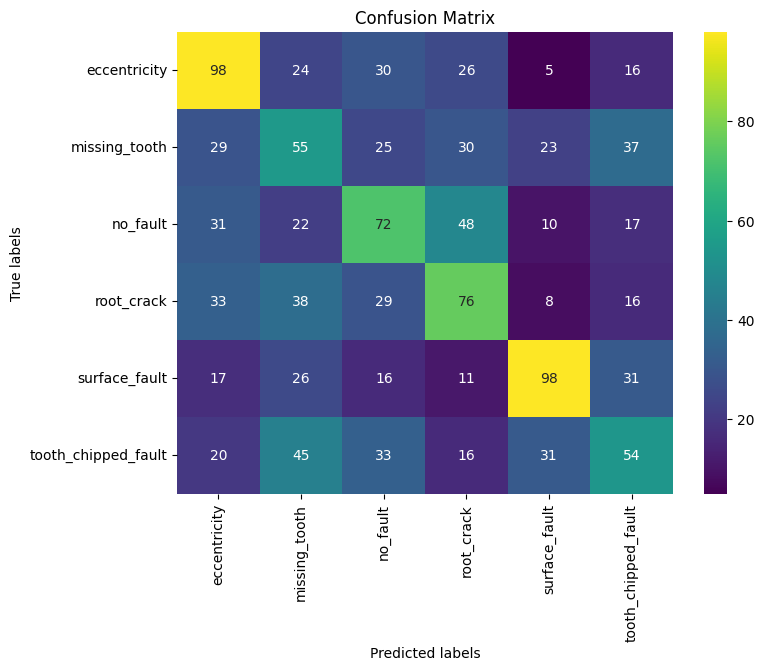

In [18]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
roc_auc_score(y_test, d_tree.predict_proba(X_test), multi_class='ovr')

0.6272634793039287

Градиентный бустинг

In [20]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [21]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, n_trials=100)

[I 2024-05-20 19:21:10,558] A new study created in memory with name: Boosting
[I 2024-05-20 19:21:11,948] Trial 0 finished with value: 0.6244769874476988 and parameters: {'learning_rate': 0.7105461208781103, 'num_leaves': 3593, 'reg_lambda': 0.43180438569781787, 'reg_alpha': 0.2783039424417466, 'min_child_samples': 94}. Best is trial 0 with value: 0.6244769874476988.
[I 2024-05-20 19:21:14,390] Trial 1 finished with value: 0.608786610878661 and parameters: {'learning_rate': 0.4784933348643793, 'num_leaves': 3919, 'reg_lambda': 0.3118491530296589, 'reg_alpha': 0.17706009572938564, 'min_child_samples': 21}. Best is trial 0 with value: 0.6244769874476988.
[I 2024-05-20 19:21:15,708] Trial 2 finished with value: 0.5094142259414226 and parameters: {'learning_rate': 1.0188974180546881, 'num_leaves': 2502, 'reg_lambda': 0.19263091955614708, 'reg_alpha': 0.4127470400835226, 'min_child_samples': 10}. Best is trial 0 with value: 0.6244769874476988.
[I 2024-05-20 19:21:18,282] Trial 3 finished wi

[I 2024-05-20 19:22:22,777] Trial 28 finished with value: 0.6841004184100419 and parameters: {'learning_rate': 0.14083878042149867, 'num_leaves': 2037, 'reg_lambda': 0.9115290260897565, 'reg_alpha': 0.5051597314296931, 'min_child_samples': 48}. Best is trial 28 with value: 0.6841004184100419.
[I 2024-05-20 19:22:24,499] Trial 29 finished with value: 0.5721757322175732 and parameters: {'learning_rate': 0.8244063382106931, 'num_leaves': 2857, 'reg_lambda': 0.8939819629331938, 'reg_alpha': 0.3748371293618371, 'min_child_samples': 37}. Best is trial 28 with value: 0.6841004184100419.
[I 2024-05-20 19:22:26,791] Trial 30 finished with value: 0.6297071129707112 and parameters: {'learning_rate': 0.3730640614048918, 'num_leaves': 2202, 'reg_lambda': 0.7639658968161379, 'reg_alpha': 0.46991239774026167, 'min_child_samples': 65}. Best is trial 28 with value: 0.6841004184100419.
[I 2024-05-20 19:22:30,092] Trial 31 finished with value: 0.6652719665271967 and parameters: {'learning_rate': 0.138446

[I 2024-05-20 19:24:01,963] Trial 56 finished with value: 0.6809623430962343 and parameters: {'learning_rate': 0.30224086218826074, 'num_leaves': 3124, 'reg_lambda': 0.5246016546739782, 'reg_alpha': 0.18670251601648613, 'min_child_samples': 98}. Best is trial 52 with value: 0.696652719665272.
[I 2024-05-20 19:24:04,397] Trial 57 finished with value: 0.6380753138075314 and parameters: {'learning_rate': 0.5337505948118767, 'num_leaves': 2250, 'reg_lambda': 0.48958760659528966, 'reg_alpha': 0.11532954358382495, 'min_child_samples': 82}. Best is trial 52 with value: 0.696652719665272.
[I 2024-05-20 19:24:07,611] Trial 58 finished with value: 0.7060669456066946 and parameters: {'learning_rate': 0.21052069637491053, 'num_leaves': 1967, 'reg_lambda': 0.6177114358764701, 'reg_alpha': 0.2464177355823767, 'min_child_samples': 91}. Best is trial 58 with value: 0.7060669456066946.
[I 2024-05-20 19:24:10,625] Trial 59 finished with value: 0.6694560669456067 and parameters: {'learning_rate': 0.25597

[I 2024-05-20 19:25:30,983] Trial 84 finished with value: 0.6746861924686193 and parameters: {'learning_rate': 0.23823929544100608, 'num_leaves': 3349, 'reg_lambda': 0.4462655758406332, 'reg_alpha': 0.260230318316668, 'min_child_samples': 96}. Best is trial 58 with value: 0.7060669456066946.
[I 2024-05-20 19:25:33,902] Trial 85 finished with value: 0.6642259414225942 and parameters: {'learning_rate': 0.2857754351013897, 'num_leaves': 2839, 'reg_lambda': 0.6413967711050547, 'reg_alpha': 0.20947669046335946, 'min_child_samples': 92}. Best is trial 58 with value: 0.7060669456066946.
[I 2024-05-20 19:25:37,669] Trial 86 finished with value: 0.6799163179916318 and parameters: {'learning_rate': 0.09505421439387793, 'num_leaves': 3278, 'reg_lambda': 0.5471538018898695, 'reg_alpha': 0.37414188844356555, 'min_child_samples': 85}. Best is trial 58 with value: 0.7060669456066946.
[I 2024-05-20 19:25:40,219] Trial 87 finished with value: 0.6589958158995816 and parameters: {'learning_rate': 0.36953

In [22]:
study.best_params

{'learning_rate': 0.21052069637491053,
 'num_leaves': 1967,
 'reg_lambda': 0.6177114358764701,
 'reg_alpha': 0.2464177355823767,
 'min_child_samples': 91}

In [23]:
boosting_clf = LGBMClassifier(verbose=-1, **study.best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.6546822742474916

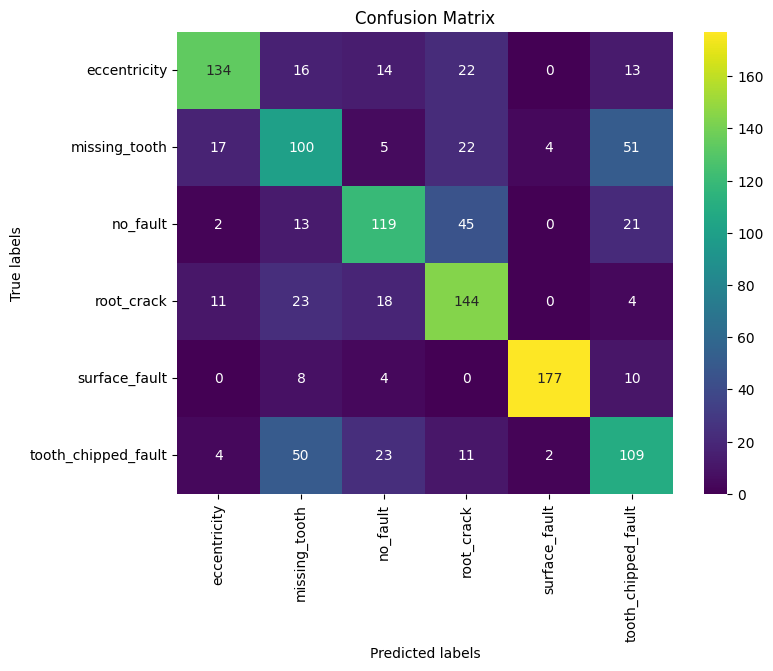

In [24]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
roc_auc_score(y_test, boosting_clf.predict_proba(X_test), multi_class='ovr')

0.9240082138076353

Градиентный бустинг дал лучший результат

**Преобразование Фурье**

In [26]:
df = get_all_features_and_targets(n_cols=150, do_fft=True)
df

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,eccentricity,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,eccentricity,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,eccentricity,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,eccentricity,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,80.0
5972,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,80.0
5973,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,80.0
5974,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,80.0


In [27]:
X = df.drop(columns='defect')
y = df['defect']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

Логистическая регрессия

In [29]:
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_score(y_test, predictions)

0.6212374581939799

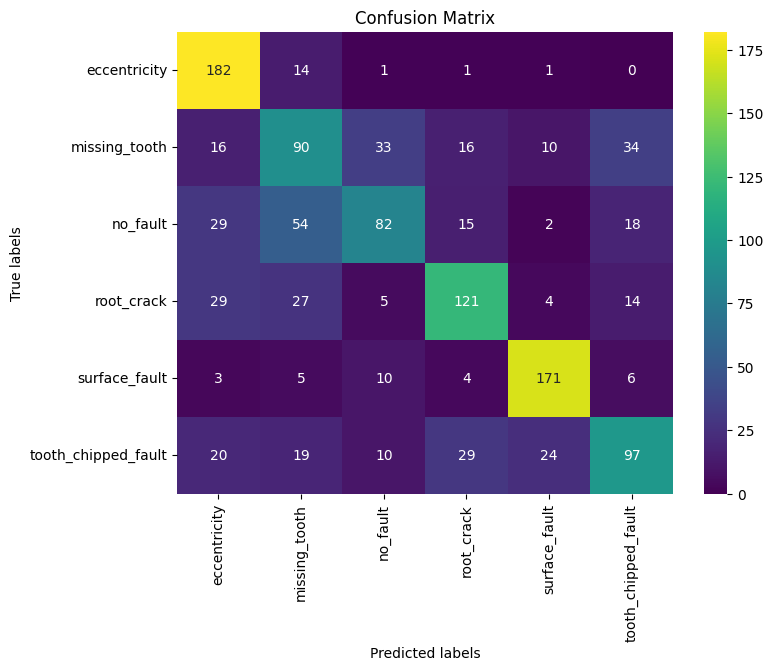

In [30]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class='ovr')

0.8926457642032674

Дерево решений

In [32]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-20 19:27:28,118] A new study created in memory with name: Tree
[I 2024-05-20 19:27:29,107] Trial 0 finished with value: 0.8608786610878661 and parameters: {'max_depth': 57}. Best is trial 0 with value: 0.8608786610878661.
[I 2024-05-20 19:27:30,063] Trial 1 finished with value: 0.852510460251046 and parameters: {'max_depth': 18}. Best is trial 0 with value: 0.8608786610878661.
[I 2024-05-20 19:27:31,019] Trial 2 finished with value: 0.8577405857740585 and parameters: {'max_depth': 94}. Best is trial 0 with value: 0.8608786610878661.
[I 2024-05-20 19:27:31,967] Trial 3 finished with value: 0.850418410041841 and parameters: {'max_depth': 96}. Best is trial 0 with value: 0.8608786610878661.
[I 2024-05-20 19:27:32,913] Trial 4 finished with value: 0.8608786610878661 and parameters: {'max_depth': 94}. Best is trial 0 with value: 0.8608786610878661.
[I 2024-05-20 19:27:33,826] Trial 5 finished with value: 0.8619246861924686 and parameters: {'max_depth': 91}. Best is trial 5 with v

In [33]:
study.best_params

{'max_depth': 79}

In [34]:
d_tree = DecisionTreeClassifier(**study.best_params)
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_score(y_test, predictions)

0.8193979933110368

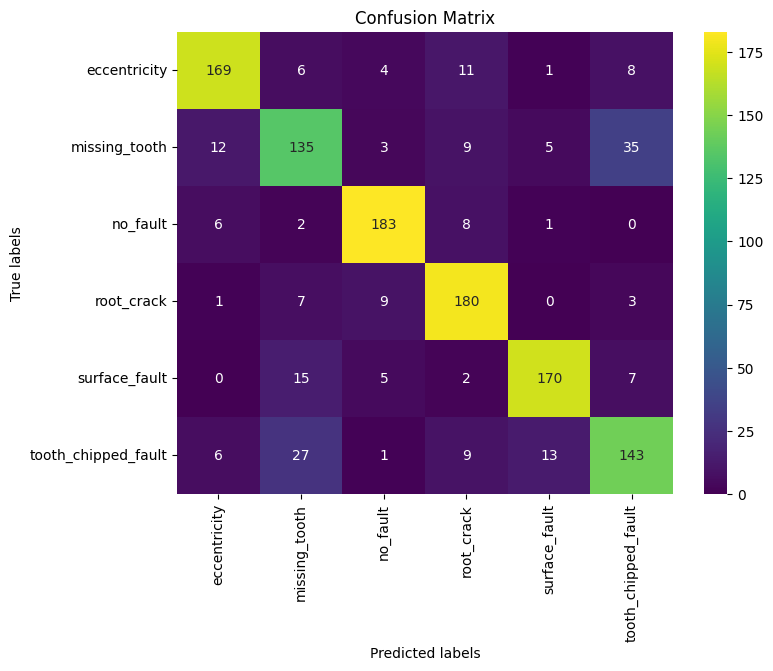

In [35]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
roc_auc_score(y_test, d_tree.predict_proba(X_test), multi_class='ovr')

0.8915659277871287

Градиентный бустинг

In [37]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [38]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, n_trials=100)

[I 2024-05-20 19:28:14,225] A new study created in memory with name: Boosting
[I 2024-05-20 19:28:14,667] Trial 0 finished with value: 0.9037656903765691 and parameters: {'learning_rate': 0.9011781020179094, 'num_leaves': 2806, 'reg_lambda': 0.5778709270008413, 'reg_alpha': 0.429444209948619, 'min_child_samples': 7}. Best is trial 0 with value: 0.9037656903765691.
[I 2024-05-20 19:28:14,833] Trial 1 finished with value: 0.9205020920502092 and parameters: {'learning_rate': 1.0746054557394882, 'num_leaves': 175, 'reg_lambda': 0.44566113064830226, 'reg_alpha': 0.38267372070657446, 'min_child_samples': 89}. Best is trial 1 with value: 0.9205020920502092.
[I 2024-05-20 19:28:15,071] Trial 2 finished with value: 0.9058577405857741 and parameters: {'learning_rate': 0.95623435073858, 'num_leaves': 783, 'reg_lambda': 0.0636441612843035, 'reg_alpha': 0.5195046814992105, 'min_child_samples': 23}. Best is trial 1 with value: 0.9205020920502092.
[I 2024-05-20 19:28:15,481] Trial 3 finished with val

[I 2024-05-20 19:28:40,231] Trial 28 finished with value: 0.9372384937238494 and parameters: {'learning_rate': 0.7784522261915523, 'num_leaves': 2255, 'reg_lambda': 0.37702097533359896, 'reg_alpha': 0.18598958985963754, 'min_child_samples': 86}. Best is trial 20 with value: 0.9592050209205021.
[I 2024-05-20 19:28:41,521] Trial 29 finished with value: 0.9560669456066946 and parameters: {'learning_rate': 0.3213100429723067, 'num_leaves': 2950, 'reg_lambda': 0.5616517820379586, 'reg_alpha': 0.097627314795071, 'min_child_samples': 95}. Best is trial 20 with value: 0.9592050209205021.
[I 2024-05-20 19:28:42,363] Trial 30 finished with value: 0.9424686192468619 and parameters: {'learning_rate': 0.8118355896372711, 'num_leaves': 3410, 'reg_lambda': 0.6254428761169722, 'reg_alpha': 0.2241887691447402, 'min_child_samples': 81}. Best is trial 20 with value: 0.9592050209205021.
[I 2024-05-20 19:28:43,407] Trial 31 finished with value: 0.9571129707112971 and parameters: {'learning_rate': 0.3588223

[I 2024-05-20 19:29:15,524] Trial 56 finished with value: 0.9518828451882845 and parameters: {'learning_rate': 0.38972055428004143, 'num_leaves': 2649, 'reg_lambda': 0.4348941395683978, 'reg_alpha': 0.28108721773869183, 'min_child_samples': 84}. Best is trial 33 with value: 0.9623430962343096.
[I 2024-05-20 19:29:16,719] Trial 57 finished with value: 0.9550209205020921 and parameters: {'learning_rate': 0.1311683491303049, 'num_leaves': 1516, 'reg_lambda': 0.6756451174085893, 'reg_alpha': 0.3825917433306844, 'min_child_samples': 75}. Best is trial 33 with value: 0.9623430962343096.
[I 2024-05-20 19:29:18,109] Trial 58 finished with value: 0.9623430962343096 and parameters: {'learning_rate': 0.20061337778535643, 'num_leaves': 2931, 'reg_lambda': 0.36349974970199955, 'reg_alpha': 0.18438362646737044, 'min_child_samples': 95}. Best is trial 33 with value: 0.9623430962343096.
[I 2024-05-20 19:29:19,243] Trial 59 finished with value: 0.9571129707112971 and parameters: {'learning_rate': 0.300

[I 2024-05-20 19:29:51,319] Trial 84 finished with value: 0.9612970711297071 and parameters: {'learning_rate': 0.28704005865097565, 'num_leaves': 2310, 'reg_lambda': 0.3761429509645276, 'reg_alpha': 0.01489000893265903, 'min_child_samples': 100}. Best is trial 33 with value: 0.9623430962343096.
[I 2024-05-20 19:29:52,260] Trial 85 finished with value: 0.9571129707112971 and parameters: {'learning_rate': 0.3048915286130083, 'num_leaves': 2302, 'reg_lambda': 0.3633946284086824, 'reg_alpha': 0.23387037584379516, 'min_child_samples': 97}. Best is trial 33 with value: 0.9623430962343096.
[I 2024-05-20 19:29:53,698] Trial 86 finished with value: 0.9592050209205021 and parameters: {'learning_rate': 0.36308946173960943, 'num_leaves': 2175, 'reg_lambda': 0.42415073910879125, 'reg_alpha': 0.023740830186215058, 'min_child_samples': 72}. Best is trial 33 with value: 0.9623430962343096.
[I 2024-05-20 19:29:55,366] Trial 87 finished with value: 0.9560669456066946 and parameters: {'learning_rate': 0.

In [39]:
study.best_params

{'learning_rate': 0.236556168819309,
 'num_leaves': 2541,
 'reg_lambda': 0.3855204506337597,
 'reg_alpha': 0.12216414446099112,
 'min_child_samples': 99}

In [40]:
best_params = {'learning_rate': 0.2403462227354661,
 'num_leaves': 3463,
 'reg_lambda': 0.003914470135492306,
 'reg_alpha': 0.0961882352006507,
 'min_child_samples': 99}

In [41]:
boosting_clf = LGBMClassifier(verbose=-1, **study.best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9456521739130435

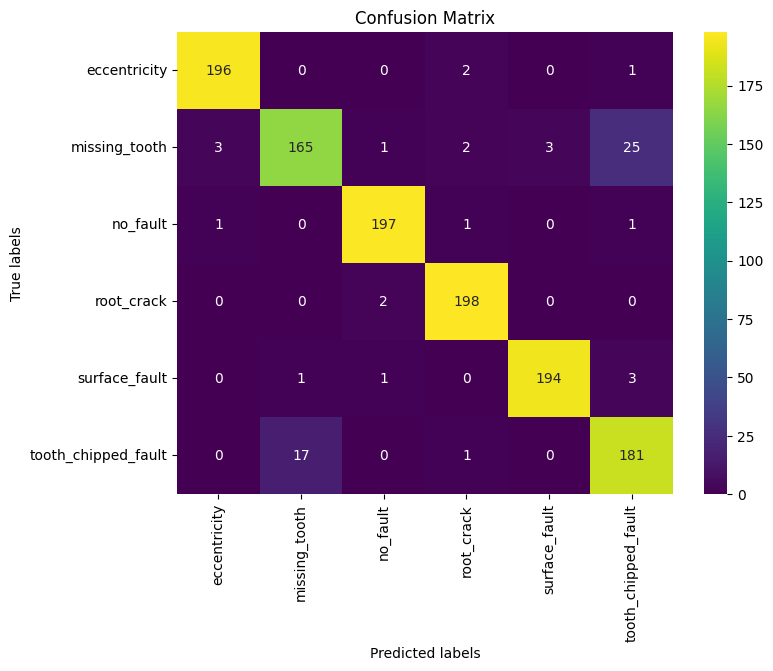

In [42]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
roc_auc_score(y_test, boosting_clf.predict_proba(X_test), multi_class='ovr')

0.9967745750647232

## Бинарная классификация

In [289]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [290]:
df = get_all_features_and_targets(n_cols=150, do_fft=False)
df

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,velocity,load
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672,8.332031,0.0
1,eccentricity,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622,8.332031,0.0
2,eccentricity,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029,8.332031,0.0
3,eccentricity,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815,8.332031,0.0
4,eccentricity,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734,40.000000,80.0
5972,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246,40.000000,80.0
5973,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261,40.000000,80.0
5974,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658,40.000000,80.0


In [291]:
df['defect'] = np.where(df['defect'] == 'no_fault', 0, 1)
df

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,velocity,load
0,1,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672,8.332031,0.0
1,1,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622,8.332031,0.0
2,1,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029,8.332031,0.0
3,1,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815,8.332031,0.0
4,1,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,1,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734,40.000000,80.0
5972,1,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246,40.000000,80.0
5973,1,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261,40.000000,80.0
5974,1,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658,40.000000,80.0


In [292]:
X = df.drop(columns='defect')
y = df['defect']

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

In [294]:
labels = [1, 0]

Логистическая регрессия

In [295]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_score(y_test, predictions)

0.8336120401337793

In [296]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"f1 = {f1}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8336120401337793
Recall = 1.0
f1 = 0.9092567259461924
roc_auc = 0.4457644289652879


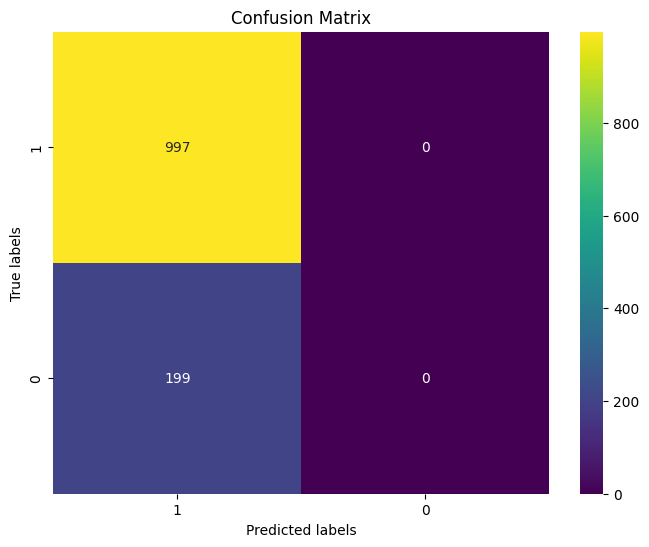

In [297]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

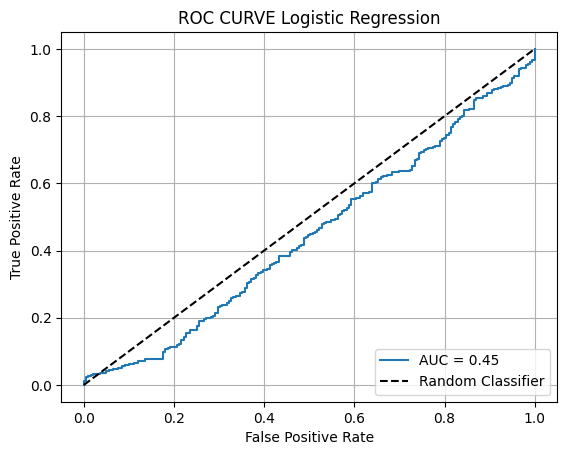

In [299]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

Дерево решений

In [300]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-20 20:48:07,717] A new study created in memory with name: Tree
[I 2024-05-20 20:48:08,742] Trial 0 finished with value: 0.6473371053399936 and parameters: {'max_depth': 49}. Best is trial 0 with value: 0.6473371053399936.
[I 2024-05-20 20:48:09,828] Trial 1 finished with value: 0.6681028700393772 and parameters: {'max_depth': 39}. Best is trial 1 with value: 0.6681028700393772.
[I 2024-05-20 20:48:10,943] Trial 2 finished with value: 0.6485997017116072 and parameters: {'max_depth': 81}. Best is trial 1 with value: 0.6681028700393772.
[I 2024-05-20 20:48:12,058] Trial 3 finished with value: 0.6832421896577574 and parameters: {'max_depth': 11}. Best is trial 3 with value: 0.6832421896577574.
[I 2024-05-20 20:48:13,188] Trial 4 finished with value: 0.6630603757802451 and parameters: {'max_depth': 47}. Best is trial 3 with value: 0.6832421896577574.
[I 2024-05-20 20:48:14,347] Trial 5 finished with value: 0.6636877283523906 and parameters: {'max_depth': 97}. Best is trial 3 with

In [301]:
study.best_params

{'max_depth': 6}

In [302]:
d_tree = DecisionTreeClassifier(**study.best_params)
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_score(y_test, predictions)

0.7801003344481605

In [303]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, d_tree.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"f1 = {f1}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8722109533468559
Recall = 0.8625877632898696
f1 = 0.8673726676752395
roc_auc = 0.6985327842824958


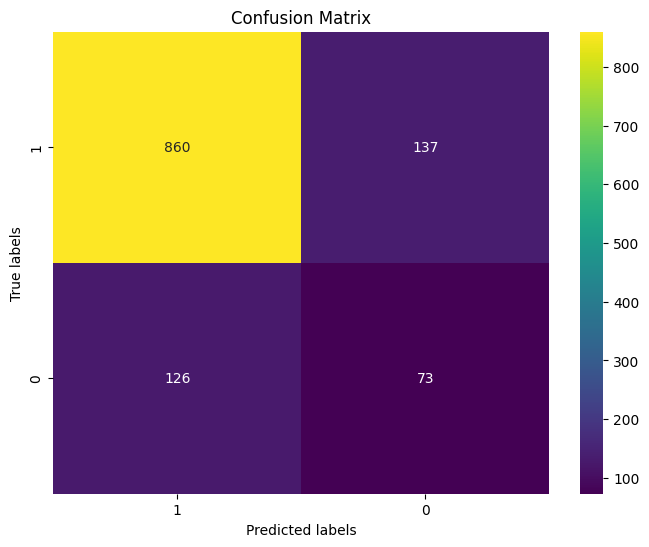

In [304]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

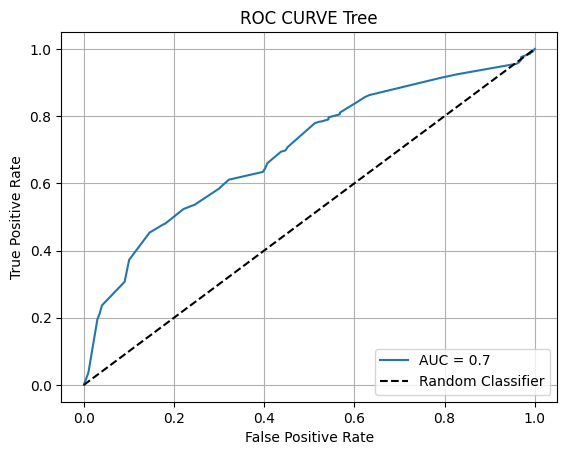

In [305]:
y_pred_proba = d_tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Tree')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

Градиентный бустинг

In [306]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'binary',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc
    

In [307]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, n_trials=100)

[I 2024-05-20 20:49:06,578] A new study created in memory with name: Boosting
[I 2024-05-20 20:49:07,376] Trial 0 finished with value: 0.7467941889001997 and parameters: {'learning_rate': 1.794434320077078, 'num_leaves': 3186, 'reg_lambda': 0.4022101643491097, 'reg_alpha': 0.24805942397148373, 'min_child_samples': 20}. Best is trial 0 with value: 0.7467941889001997.
[I 2024-05-20 20:49:07,984] Trial 1 finished with value: 0.8186043575357276 and parameters: {'learning_rate': 1.5625394473469123, 'num_leaves': 2693, 'reg_lambda': 0.5426535348780682, 'reg_alpha': 0.4967226076009228, 'min_child_samples': 43}. Best is trial 1 with value: 0.8186043575357276.
[I 2024-05-20 20:49:08,772] Trial 2 finished with value: 0.8906354805362878 and parameters: {'learning_rate': 0.8083561905295401, 'num_leaves': 3192, 'reg_lambda': 0.348643728973856, 'reg_alpha': 0.23466231293881135, 'min_child_samples': 69}. Best is trial 2 with value: 0.8906354805362878.
[I 2024-05-20 20:49:09,523] Trial 3 finished with

[I 2024-05-20 20:49:42,952] Trial 28 finished with value: 0.9283318734562787 and parameters: {'learning_rate': 0.1972980364833315, 'num_leaves': 2865, 'reg_lambda': 0.08811098662591013, 'reg_alpha': 0.3060558493171064, 'min_child_samples': 74}. Best is trial 22 with value: 0.943269966777933.
[I 2024-05-20 20:49:44,551] Trial 29 finished with value: 0.9139224923652375 and parameters: {'learning_rate': 0.4068261670920985, 'num_leaves': 3813, 'reg_lambda': 0.17888556007035827, 'reg_alpha': 0.19343906386691864, 'min_child_samples': 24}. Best is trial 22 with value: 0.943269966777933.
[I 2024-05-20 20:49:47,968] Trial 30 finished with value: 0.8603568412995273 and parameters: {'learning_rate': 0.00826400440729158, 'num_leaves': 2106, 'reg_lambda': 0.33530607901359816, 'reg_alpha': 0.06564379697732849, 'min_child_samples': 14}. Best is trial 22 with value: 0.943269966777933.
[I 2024-05-20 20:49:49,833] Trial 31 finished with value: 0.9273770349502458 and parameters: {'learning_rate': 0.27444

[I 2024-05-20 20:50:25,657] Trial 56 finished with value: 0.923660266881308 and parameters: {'learning_rate': 0.3802376204421703, 'num_leaves': 3243, 'reg_lambda': 0.1223222530855216, 'reg_alpha': 0.09143190501430828, 'min_child_samples': 40}. Best is trial 22 with value: 0.943269966777933.
[I 2024-05-20 20:50:28,842] Trial 57 finished with value: 0.9058497668142327 and parameters: {'learning_rate': 0.12366495083068052, 'num_leaves': 4080, 'reg_lambda': 0.26108337354349503, 'reg_alpha': 0.1309993573068461, 'min_child_samples': 7}. Best is trial 22 with value: 0.943269966777933.
[I 2024-05-20 20:50:30,795] Trial 58 finished with value: 0.9204722110429835 and parameters: {'learning_rate': 0.23897055329880396, 'num_leaves': 2691, 'reg_lambda': 0.07425363159071124, 'reg_alpha': 0.034310047361688585, 'min_child_samples': 27}. Best is trial 22 with value: 0.943269966777933.
[I 2024-05-20 20:50:31,959] Trial 59 finished with value: 0.9262564806704386 and parameters: {'learning_rate': 0.485107

[I 2024-05-20 20:51:07,534] Trial 84 finished with value: 0.9381564514728975 and parameters: {'learning_rate': 0.3162342936224623, 'num_leaves': 3102, 'reg_lambda': 0.02453695469782552, 'reg_alpha': 0.05605380600362403, 'min_child_samples': 77}. Best is trial 22 with value: 0.943269966777933.
[I 2024-05-20 20:51:08,685] Trial 85 finished with value: 0.9325694625285069 and parameters: {'learning_rate': 0.35968461022578013, 'num_leaves': 2951, 'reg_lambda': 0.021890109008845134, 'reg_alpha': 0.05689223203274374, 'min_child_samples': 57}. Best is trial 22 with value: 0.943269966777933.
[I 2024-05-20 20:51:10,047] Trial 86 finished with value: 0.9392770057527048 and parameters: {'learning_rate': 0.3137638309597927, 'num_leaves': 3065, 'reg_lambda': 0.0627594606514164, 'reg_alpha': 0.08186921597445648, 'min_child_samples': 67}. Best is trial 22 with value: 0.943269966777933.
[I 2024-05-20 20:51:11,494] Trial 87 finished with value: 0.936893855101284 and parameters: {'learning_rate': 0.30203

In [308]:
study.best_params

{'learning_rate': 0.15354780013017905,
 'num_leaves': 3720,
 'reg_lambda': 0.09044505520222441,
 'reg_alpha': 0.0005937441498047198,
 'min_child_samples': 36}

In [309]:
boosting_clf = LGBMClassifier(verbose=-1, **study.best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.8954849498327759

In [310]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, boosting_clf.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"f1 = {f1}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8920863309352518
Recall = 0.9949849548645938
f1 = 0.9407302038880986
roc_auc = 0.9410694394742014


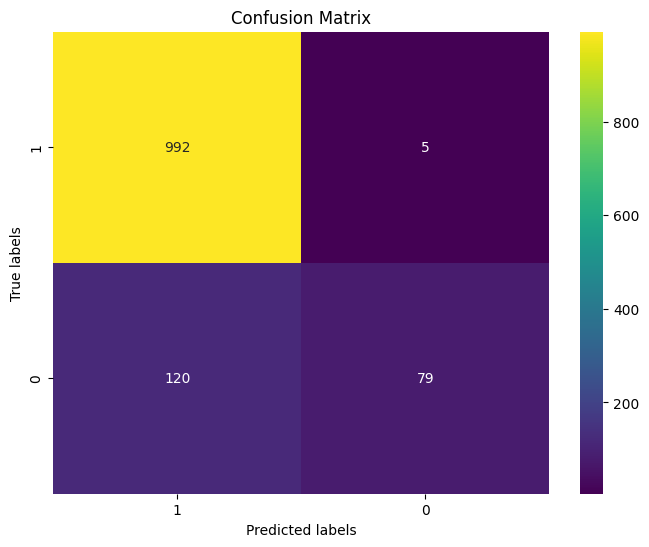

In [311]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

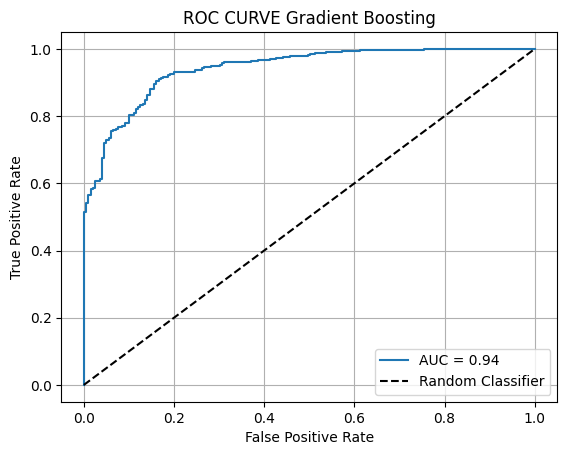

In [312]:
y_pred_proba = boosting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Gradient Boosting')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

**Фурье**

In [313]:
df = get_all_features_and_targets(n_cols=150, do_fft=True)
df

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,eccentricity,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,eccentricity,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,eccentricity,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,eccentricity,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,80.0
5972,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,80.0
5973,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,80.0
5974,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,80.0


In [314]:
df['defect'] = np.where(df['defect'] == 'no_fault', 0, 1)
df

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,1,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,1,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,1,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,1,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,1,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,1,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,80.0
5972,1,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,80.0
5973,1,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,80.0
5974,1,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,80.0


In [315]:
X = df.drop(columns='defect')
y = df['defect']

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

Логистическая регрессия

In [317]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_score(y_test, predictions)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8503344481605352

In [318]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8495726495726496
Recall = 0.9969909729187563
roc_auc = 0.8092770774635465


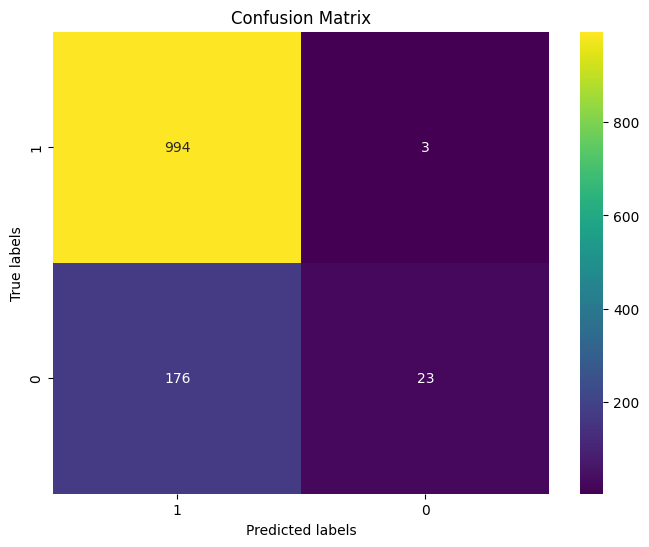

In [319]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

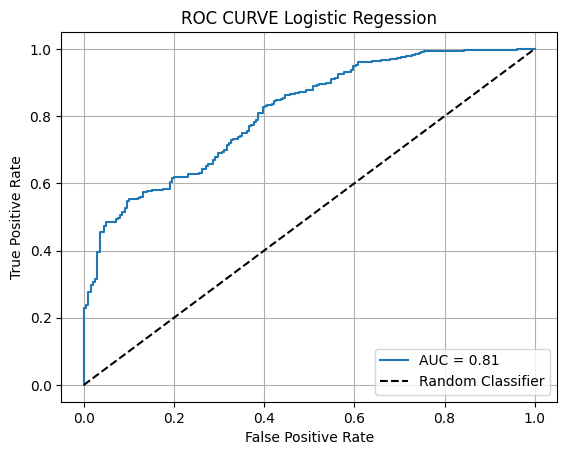

In [320]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Logistic Regession')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

Дерево решений

In [321]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-20 20:52:17,882] A new study created in memory with name: Tree
[I 2024-05-20 20:52:18,333] Trial 0 finished with value: 0.9402752460090118 and parameters: {'max_depth': 78}. Best is trial 0 with value: 0.9402752460090118.
[I 2024-05-20 20:52:18,806] Trial 1 finished with value: 0.9352406429772022 and parameters: {'max_depth': 75}. Best is trial 0 with value: 0.9402752460090118.
[I 2024-05-20 20:52:19,277] Trial 2 finished with value: 0.9434120088697395 and parameters: {'max_depth': 32}. Best is trial 2 with value: 0.9434120088697395.
[I 2024-05-20 20:52:19,751] Trial 3 finished with value: 0.9434120088697395 and parameters: {'max_depth': 15}. Best is trial 2 with value: 0.9434120088697395.
[I 2024-05-20 20:52:19,839] Trial 4 finished with value: 0.7342431918436275 and parameters: {'max_depth': 1}. Best is trial 2 with value: 0.9434120088697395.
[I 2024-05-20 20:52:20,321] Trial 5 finished with value: 0.944039361441885 and parameters: {'max_depth': 80}. Best is trial 5 with v

In [322]:
study.best_params

{'max_depth': 6}

In [323]:
d_tree = DecisionTreeClassifier(**study.best_params)
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_score(y_test, predictions)

0.9607023411371237

In [324]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, d_tree.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.9693675889328063
Recall = 0.9839518555667001
roc_auc = 0.9578811812321387


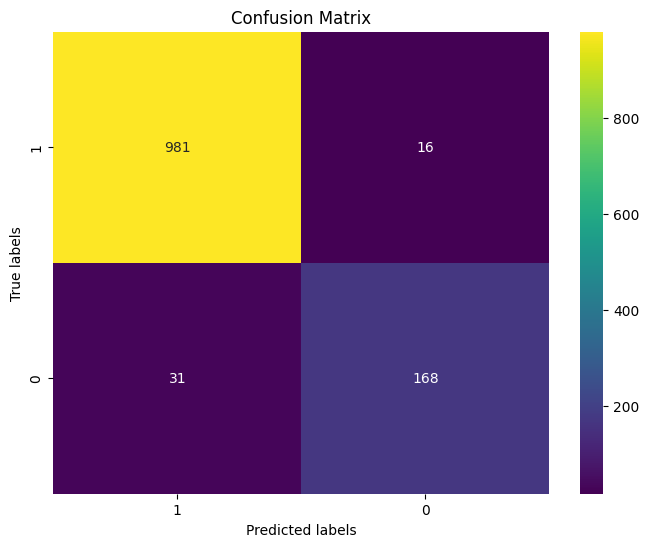

In [325]:
cm = confusion_matrix(y_test, predictions, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

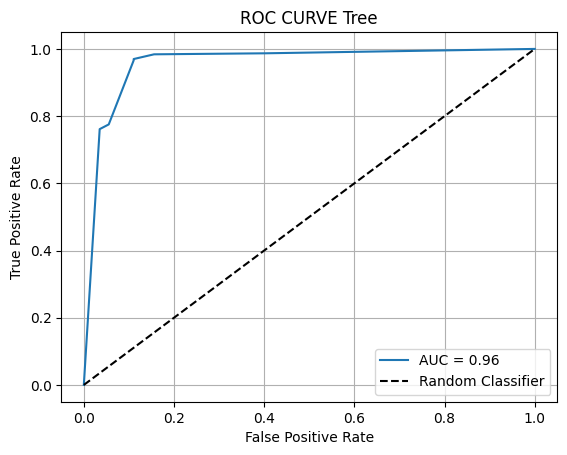

In [326]:
y_pred_proba = d_tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 2)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Tree')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

Градиентный бустинг

In [327]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'binary',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc
    

In [328]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, n_trials=100)

[I 2024-05-20 20:52:44,195] A new study created in memory with name: Boosting
[I 2024-05-20 20:52:44,468] Trial 0 finished with value: 0.9977510002130632 and parameters: {'learning_rate': 1.1647458867373315, 'num_leaves': 3250, 'reg_lambda': 0.966201404532833, 'reg_alpha': 0.43789307671767874, 'min_child_samples': 18}. Best is trial 0 with value: 0.9977510002130632.
[I 2024-05-20 20:52:44,588] Trial 1 finished with value: 0.9986506001278379 and parameters: {'learning_rate': 1.0752324542853622, 'num_leaves': 1217, 'reg_lambda': 0.28229604927604446, 'reg_alpha': 0.9054991547766837, 'min_child_samples': 10}. Best is trial 1 with value: 0.9986506001278379.
[I 2024-05-20 20:52:44,740] Trial 2 finished with value: 0.9993844842688384 and parameters: {'learning_rate': 0.7790412024774843, 'num_leaves': 1520, 'reg_lambda': 0.8889625897536781, 'reg_alpha': 0.3780827197102894, 'min_child_samples': 44}. Best is trial 2 with value: 0.9993844842688384.
[I 2024-05-20 20:52:45,331] Trial 3 finished wit

[I 2024-05-20 20:52:52,335] Trial 28 finished with value: 0.9997948280896127 and parameters: {'learning_rate': 0.2944810726845362, 'num_leaves': 1894, 'reg_lambda': 0.43926033596848924, 'reg_alpha': 0.9997411136055816, 'min_child_samples': 81}. Best is trial 28 with value: 0.9997948280896127.
[I 2024-05-20 20:52:52,856] Trial 29 finished with value: 0.9995975474065482 and parameters: {'learning_rate': 0.18400239538878557, 'num_leaves': 1956, 'reg_lambda': 0.9893602848706919, 'reg_alpha': 0.469609863528629, 'min_child_samples': 80}. Best is trial 28 with value: 0.9997948280896127.
[I 2024-05-20 20:52:53,039] Trial 30 finished with value: 0.9996922421344192 and parameters: {'learning_rate': 0.280620702209433, 'num_leaves': 426, 'reg_lambda': 0.46240490751483154, 'reg_alpha': 0.6395518260557651, 'min_child_samples': 24}. Best is trial 28 with value: 0.9997948280896127.
[I 2024-05-20 20:52:53,225] Trial 31 finished with value: 0.9995265263606449 and parameters: {'learning_rate': 0.30785132

[I 2024-05-20 20:53:00,990] Trial 56 finished with value: 0.9990214878119994 and parameters: {'learning_rate': 0.45105462733755114, 'num_leaves': 2068, 'reg_lambda': 0.6023570104178075, 'reg_alpha': 0.8737758768598192, 'min_child_samples': 84}. Best is trial 28 with value: 0.9997948280896127.
[I 2024-05-20 20:53:01,530] Trial 57 finished with value: 0.9995265263606449 and parameters: {'learning_rate': 0.19929372118925356, 'num_leaves': 2547, 'reg_lambda': 0.4855553621964081, 'reg_alpha': 0.8286200292575109, 'min_child_samples': 75}. Best is trial 28 with value: 0.9997948280896127.
[I 2024-05-20 20:53:01,817] Trial 58 finished with value: 0.9993213544502576 and parameters: {'learning_rate': 0.3099243777229157, 'num_leaves': 1099, 'reg_lambda': 0.5463128848620639, 'reg_alpha': 0.7944383698715938, 'min_child_samples': 69}. Best is trial 28 with value: 0.9997948280896127.
[I 2024-05-20 20:53:02,245] Trial 59 finished with value: 0.9998342842262257 and parameters: {'learning_rate': 0.159661

[I 2024-05-20 20:53:11,175] Trial 84 finished with value: 0.9994081579508061 and parameters: {'learning_rate': 0.32799383027714046, 'num_leaves': 962, 'reg_lambda': 0.4959617549681954, 'reg_alpha': 0.7256698225932066, 'min_child_samples': 11}. Best is trial 59 with value: 0.9998342842262257.
[I 2024-05-20 20:53:11,462] Trial 85 finished with value: 0.9994870702240319 and parameters: {'learning_rate': 0.22542666177206117, 'num_leaves': 803, 'reg_lambda': 0.6186345336982173, 'reg_alpha': 0.770728646641558, 'min_child_samples': 26}. Best is trial 59 with value: 0.9998342842262257.
[I 2024-05-20 20:53:11,715] Trial 86 finished with value: 0.9997001333617417 and parameters: {'learning_rate': 0.41464329607505634, 'num_leaves': 514, 'reg_lambda': 0.43996827810664085, 'reg_alpha': 0.8488450798642876, 'min_child_samples': 21}. Best is trial 59 with value: 0.9998342842262257.
[I 2024-05-20 20:53:12,174] Trial 87 finished with value: 0.9994949614513545 and parameters: {'learning_rate': 0.05273791

In [329]:
study.best_params

{'learning_rate': 0.15966166874919707,
 'num_leaves': 1530,
 'reg_lambda': 0.4538671248334824,
 'reg_alpha': 0.7572321671619695,
 'min_child_samples': 54}

In [330]:
boosting_clf = LGBMClassifier(verbose=-1, **study.best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9874581939799331

In [332]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, boosting_clf.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.9871031746031746
Recall = 0.9979939819458375
roc_auc = 0.9992641240303826


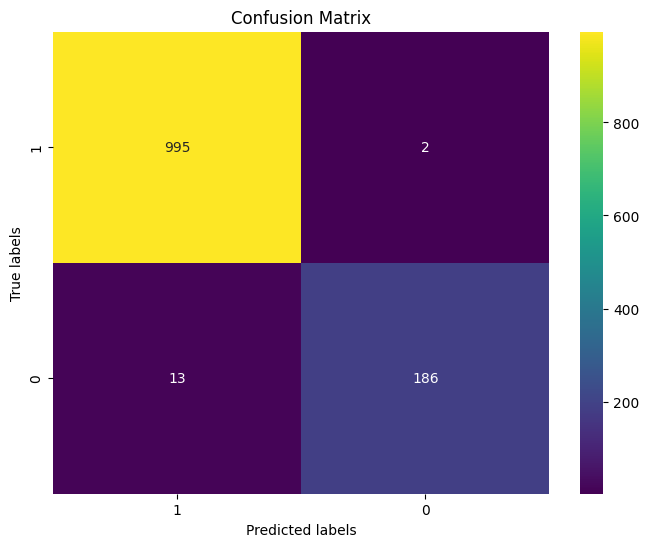

In [333]:
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

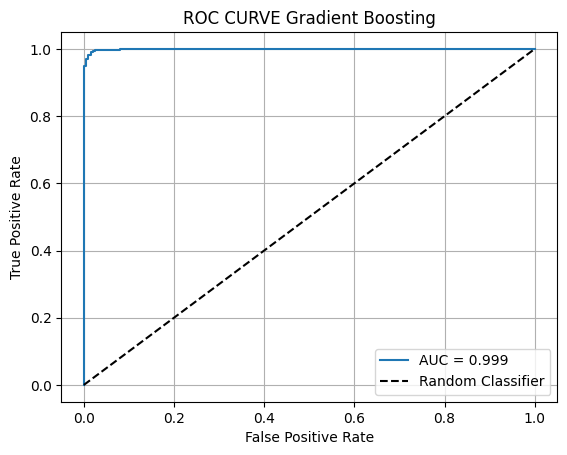

In [337]:
y_pred_proba = boosting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot (fpr,tpr,label=f"AUC = {round(auc, 3)}")
plt.plot([0, 1], [0, 1], '--k', label='Random Classifier')
plt.grid()
plt.title('ROC CURVE Gradient Boosting')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 